# 1. 요약 / 절차  

## 1.1. 데이터
  - cityscapes data : 1000개
  - image shape : (256, 512, 3)  
    
    
## 1.2. Data Augmentation
  - apply_augmentation
    - 스케치 / 채색된 이미지 2개를 입력
    - 여러 연산을 두 이미지에 동일하게 적용  
      
      
## 1.3. Generator
  - EncodeBlock : Convolution -> BatchNorm -> LeakyRelu
  - Encoder : EncodeBlock 호출
  
  - DecodeBlock : Transposed Convolution -> BatchNorm -> DropOut -> Relu
  - Decoder : DecodeBlock 호출
  
  - EncoderDecoderGenerator
    - Encoder / Decoder 호출  
      
      
    - Total params: 17,445,632
    - Trainable params: 17,440,640
    - Non-trainable params: 4,992  
      
## 1.4. U-Net
  - Encoder와 Decoder 사이를 skip connection으로 연결
  - U-Net Generator : Decoder의 파라미터가 Encoder보다 많아짐
    - 블록내 convolution 레이어에서 사용하는 필터 크기가 커짐
    - 학습해야 할 파라미터가 늘어남  
      
      
   
## 1.5. Discriminator
  - 이미지의 진짜 가짜를 판별
  - 최종 출력에 sigmoid를 사용
  - Discriminator에 사용할 기본적인 블록 : DiscBlock 순서
    - Padding 레이어 통과
    - Convolution 레이어 통과
    - BatchNormalization 레이어
    - LeakyRelu 활성화 레이어 통과
  - Discriminator : DiscBlock 호출  
    
    
  
## 1.6. 학습 / 테스트
  - Loss
    - Generator Loss
    - L1 Loss
    - Discriminator Loss
  - Epoch = 10 
    - loss 저장 및 시각화
    

# 2. 결과
## 2.1. Loss

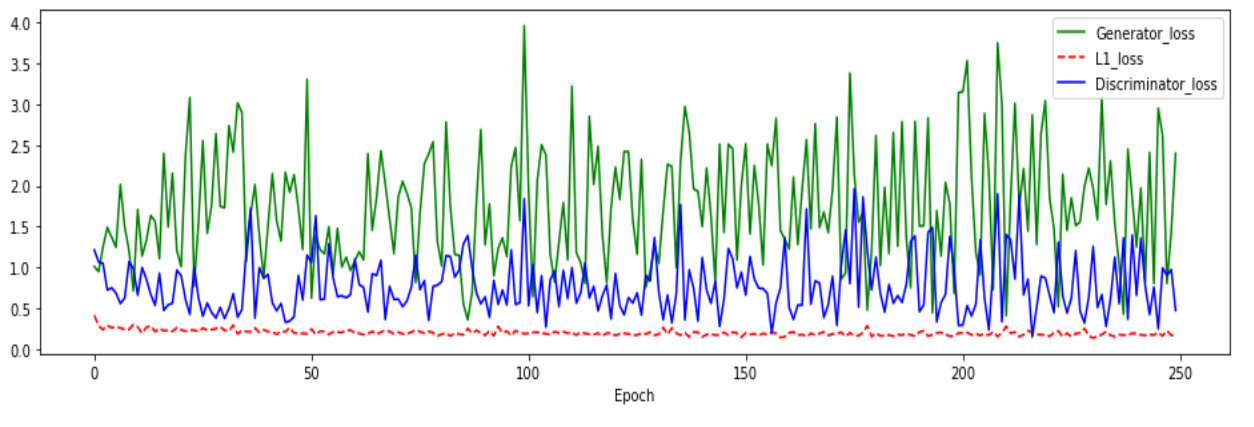

## 2.2. 이미지처리

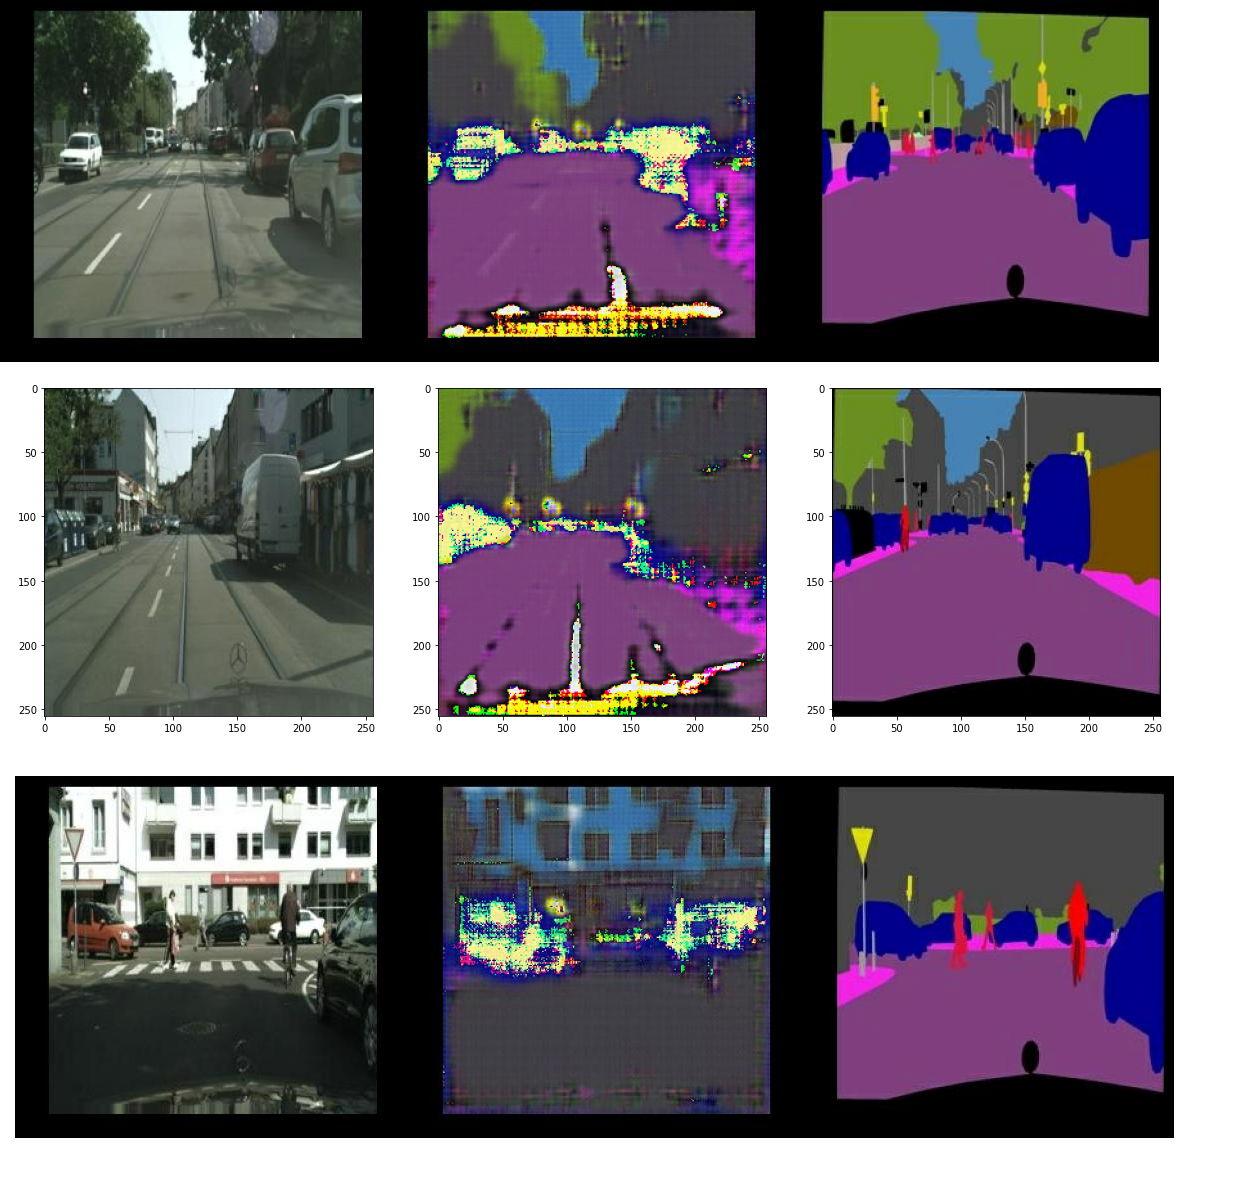

# 3. 회고
  - 느낀 점
    - 채색이 너무 단순하게 느껴짐
    - 스케치한 것에 채색하는 것이 아닌 사진에 채색을 하므로 나타나는 현상 같음
    - 코드를 제대로 이해하지 못하고 실행하는 것이 많이 아쉬움
    - 과제 제출할 때마다 느끼는 것이지만 학습이 부족함을 느낌
    - 고잉디퍼 전 마지막 과제 : 모두 제출한 것은 아니지만
    - 그래도 열심히 한 것 같음.
    - 앞으로 좀더 열심히 하자고 각오, 또 각오

In [27]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/city/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


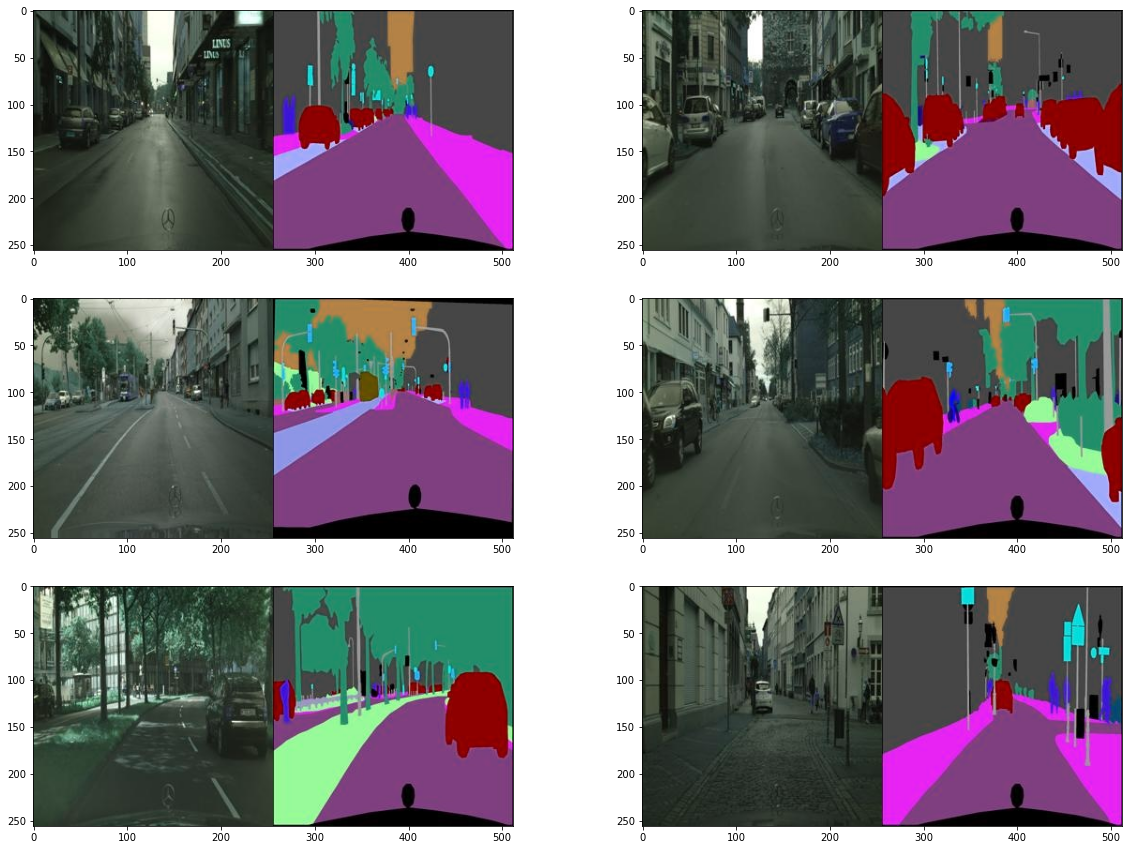

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [29]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


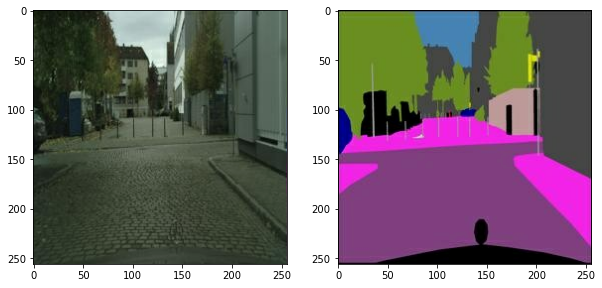

In [30]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [31]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


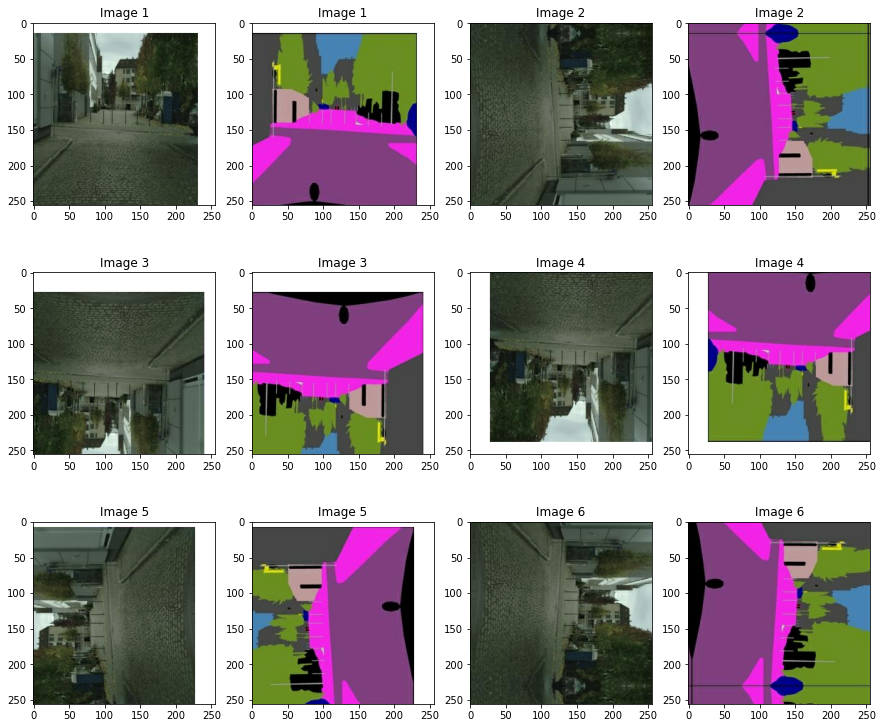

In [32]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

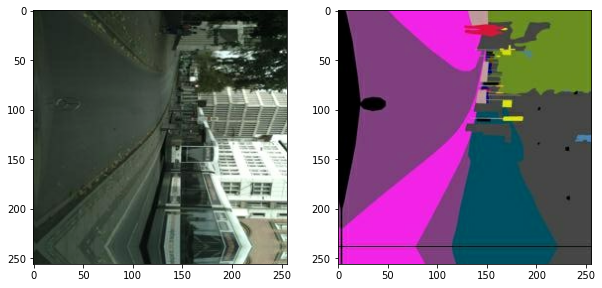

In [33]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [34]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


In [35]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [36]:
Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

In [37]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [38]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

In [39]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [40]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


In [41]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [42]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

In [43]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [44]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [45]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [46]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]      

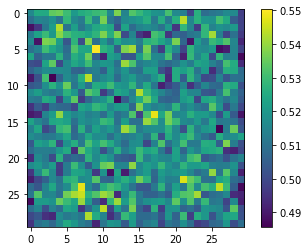

In [47]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [48]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [49]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [50]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [51]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

g_p_loss = []
l1_p_loss = []
d_p_loss = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
            g_p_loss.append(g_loss)
            l1_p_loss.append(l1_loss)
            d_p_loss.append(d_loss)

EPOCH[1] - STEP[10]                     
Generator_loss:1.0095                     
L1_loss:0.4147                     
Discriminator_loss:1.2132

EPOCH[1] - STEP[20]                     
Generator_loss:0.9480                     
L1_loss:0.2817                     
Discriminator_loss:1.0665

EPOCH[1] - STEP[30]                     
Generator_loss:1.2505                     
L1_loss:0.2373                     
Discriminator_loss:1.0503

EPOCH[1] - STEP[40]                     
Generator_loss:1.4902                     
L1_loss:0.2892                     
Discriminator_loss:0.7214

EPOCH[1] - STEP[50]                     
Generator_loss:1.3681                     
L1_loss:0.2597                     
Discriminator_loss:0.7495

EPOCH[1] - STEP[60]                     
Generator_loss:1.2471                     
L1_loss:0.2701                     
Discriminator_loss:0.6855

EPOCH[1] - STEP[70]                     
Generator_loss:2.0167                     
L1_loss:0.2574                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.4783                     
L1_loss:0.2070                     
Discriminator_loss:0.6415

EPOCH[3] - STEP[80]                     
Generator_loss:1.0049                     
L1_loss:0.2026                     
Discriminator_loss:0.6534

EPOCH[3] - STEP[90]                     
Generator_loss:1.1243                     
L1_loss:0.2264                     
Discriminator_loss:0.6280

EPOCH[3] - STEP[100]                     
Generator_loss:0.9643                     
L1_loss:0.2306                     
Discriminator_loss:0.6674

EPOCH[3] - STEP[110]                     
Generator_loss:1.0816                     
L1_loss:0.1988                     
Discriminator_loss:1.1009

EPOCH[3] - STEP[120]                     
Generator_loss:1.1937                     
L1_loss:0.1918                     
Discriminator_loss:0.7898

EPOCH[3] - STEP[130]                     
Generator_loss:1.0921                     
L1_loss:0.1768                

EPOCH[5] - STEP[130]                     
Generator_loss:1.0588                     
L1_loss:0.2049                     
Discriminator_loss:0.6868

EPOCH[5] - STEP[140]                     
Generator_loss:0.8051                     
L1_loss:0.1901                     
Discriminator_loss:1.0527

EPOCH[5] - STEP[150]                     
Generator_loss:2.8506                     
L1_loss:0.1825                     
Discriminator_loss:0.6266

EPOCH[5] - STEP[160]                     
Generator_loss:2.0181                     
L1_loss:0.1787                     
Discriminator_loss:0.7688

EPOCH[5] - STEP[170]                     
Generator_loss:2.4827                     
L1_loss:0.1927                     
Discriminator_loss:0.4682

EPOCH[5] - STEP[180]                     
Generator_loss:1.4056                     
L1_loss:0.1626                     
Discriminator_loss:0.6529

EPOCH[5] - STEP[190]                     
Generator_loss:0.8092                     
L1_loss:0.1932             

EPOCH[7] - STEP[190]                     
Generator_loss:1.6786                     
L1_loss:0.2112                     
Discriminator_loss:0.3864

EPOCH[7] - STEP[200]                     
Generator_loss:1.4272                     
L1_loss:0.1668                     
Discriminator_loss:0.5423

EPOCH[7] - STEP[210]                     
Generator_loss:1.9536                     
L1_loss:0.1857                     
Discriminator_loss:0.8913

EPOCH[7] - STEP[220]                     
Generator_loss:2.8421                     
L1_loss:0.1873                     
Discriminator_loss:0.2898

EPOCH[7] - STEP[230]                     
Generator_loss:0.8551                     
L1_loss:0.2051                     
Discriminator_loss:1.0172

EPOCH[7] - STEP[240]                     
Generator_loss:0.9348                     
L1_loss:0.1561                     
Discriminator_loss:1.4573

EPOCH[7] - STEP[250]                     
Generator_loss:3.3827                     
L1_loss:0.1973             

EPOCH[9] - STEP[250]                     
Generator_loss:1.4519                     
L1_loss:0.1932                     
Discriminator_loss:0.4423

EPOCH[10] - STEP[10]                     
Generator_loss:1.8527                     
L1_loss:0.1506                     
Discriminator_loss:0.6251

EPOCH[10] - STEP[20]                     
Generator_loss:1.5103                     
L1_loss:0.1907                     
Discriminator_loss:1.2060

EPOCH[10] - STEP[30]                     
Generator_loss:1.5577                     
L1_loss:0.1939                     
Discriminator_loss:0.4665

EPOCH[10] - STEP[40]                     
Generator_loss:1.9887                     
L1_loss:0.2528                     
Discriminator_loss:0.3196

EPOCH[10] - STEP[50]                     
Generator_loss:2.2174                     
L1_loss:0.1607                     
Discriminator_loss:0.6320

EPOCH[10] - STEP[60]                     
Generator_loss:1.9716                     
L1_loss:0.1344             

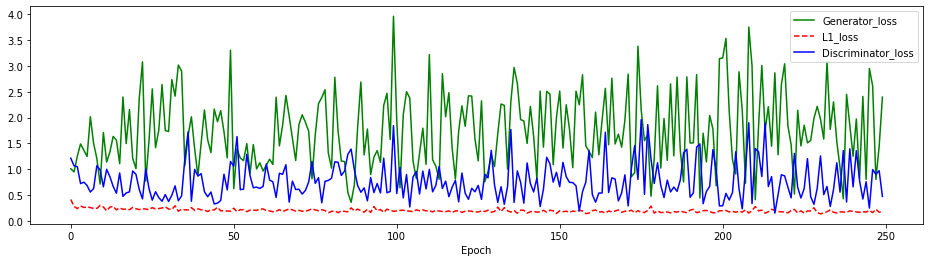

In [53]:
plt.figure(figsize=(16, 4))

plt.plot(g_p_loss, 'g-', label='Generator_loss')
plt.plot(l1_p_loss, 'r--', label='L1_loss')
plt.plot(d_p_loss, 'b-', label='Discriminator_loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [60]:
def plt_show(test_ind):
    f = val_path + os.listdir(val_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))    

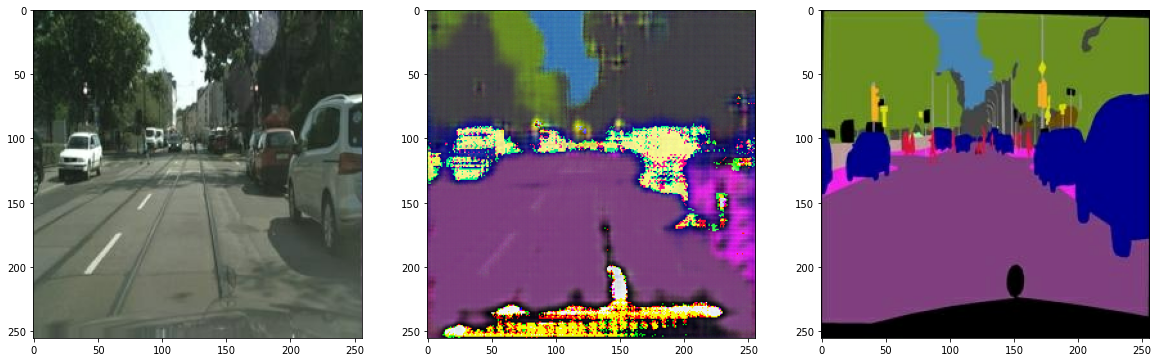

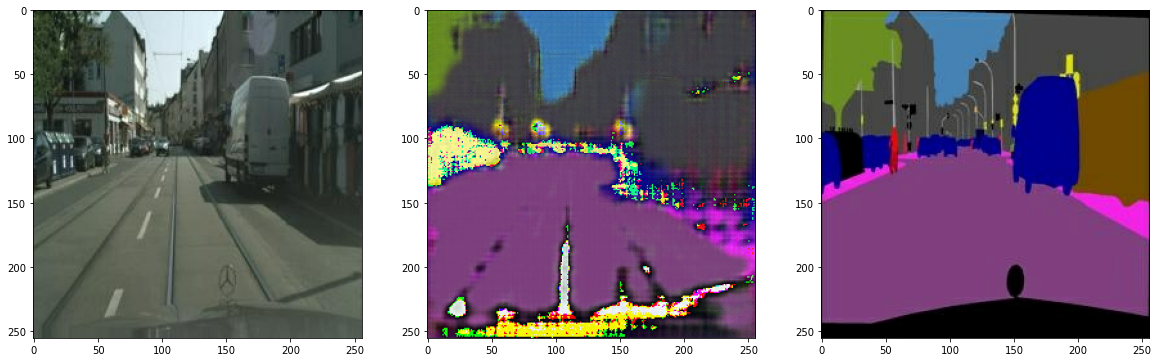

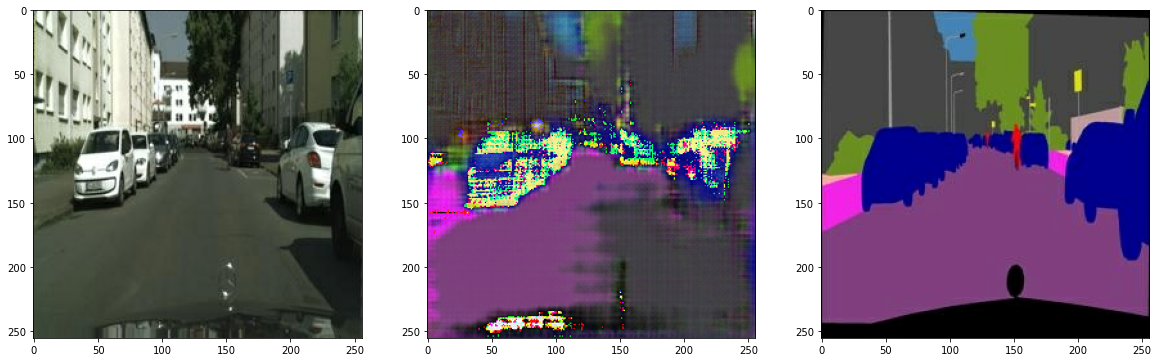

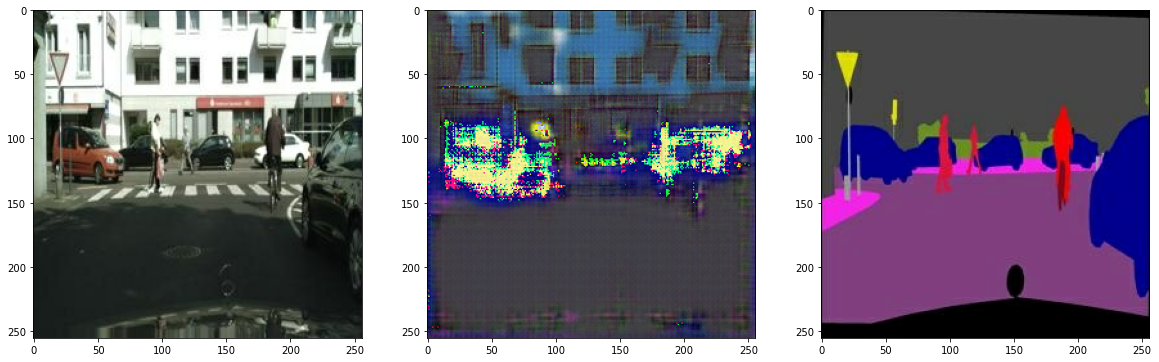

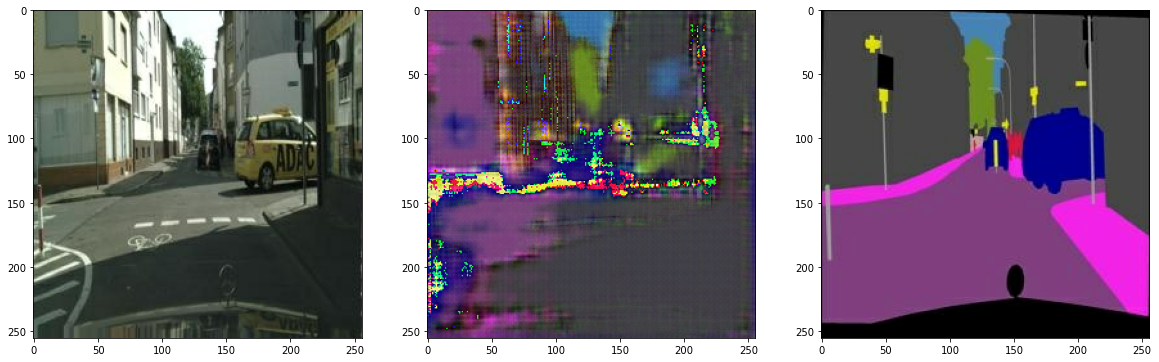

In [61]:
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/city/cityscapes/val/'

for i in range(5):
    plt_show(i)